# Projet de Simulation et Monte Carlo  
  
  Ce projet se base sur l'arcticle de Yuyang Shi et Rob Cornish : On Multilevel Monte Carlo Unbiased Gradient Estimation For Deep Latent Variable Models (2021) http://proceedings.mlr.press/v130/shi21d.html

In [93]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import random

## Partie 1 : Génération des données 
Comme dit dans l'article, nous étudions les modèles à variables latentes. pour pouvoir générer les données, nous considérerons une expérience gaussienne linéaire de la même manière que Rainforth et al. (2018) et Tucker et al. (2019)  

   On considère le modèle génératif suivant : $p_{\theta}(x,z)= \mathcal{N}(z|\theta,I)\mathcal{N}(x|z,I)$ où $x,z \in \mathbb{R^{20}}$ tel que $p_{\theta}(x)= \mathcal{N}(x|\theta,2I)$ et $p_{\theta}(z|x)= \mathcal{N}(\frac{\theta+x}{2},\frac{1}{2}I)$. La distribution de l'encodeur est $q_{\phi}(z|x)=\mathcal{N}(z|Ax+b,\frac{2}{3}I)$, où $\phi = (A,b)$. On considère une perturbation aléatoire des paramètres autour de la valeur optimale par une gaussienne centré de variance 0.01.
    

In [94]:
theta = np.random.normal(0, 1)
theta_vector = np.zeros(20)+theta
r = 0.6
A_true = 1/2*np.eye(20)
b_true = np.zeros(20)+theta/2
X_data = multivariate_normal.rvs(theta_vector, 2*np.eye(20))
print('theta = ' + str(theta))

theta = 1.3133940172700165


In [95]:
def parameter_perturbation(A, b):
    return A+np.eye(20)*np.random.normal(0, 0.01), b+np.random.normal(0, 0.01)

In [96]:
def generate_z(K, A, b, x):
    Z = []
    for i in range(2**(K+1)):
        Z.append(multivariate_normal.rvs(np.dot(A,x)+b, 2/3*np.eye(20)))
    Z_O = Z[1::2]
    Z_E = Z[::2]
    return Z,Z_O,Z_E

In [97]:
def q_phi(z, A, b, K, x):
    q = []
    for i in range(2**(K+1)):
        q.append(multivariate_normal.pdf(z[i], np.dot(A,x)+b, 2/3*np.eye(20)))
    return np.array(q)

In [98]:
def p_joint(z, K, x, mu):
    p = []
    mu_vector = np.zeros(20)+mu
    for i in range(2**(K+1)):
        p.append(multivariate_normal.pdf(z[i], mu_vector, np.eye(20))*multivariate_normal.pdf(x,z[i],np.eye(20)))
    return np.array(p)

## Partie 2 : Estimation de la vraisemblance  
  
  Dans cette partie, nous allons reproduire les estimateurs IWAE, SS, RR et SUMO cités dans l'article

### 1) Estimateur SS

In [109]:
def SS_estimator(A, b, x, mu, N_sim):
    list_ss = []
    for i in range(N_sim):
        K = np.random.geometric(r)
        Z_data, Z_data_O, Z_data_E = generate_z(K, A, b, x)
        q = q_phi(Z_data, A, b, K, x)
        p = p_joint(Z_data, K, x, mu)
        w = p/q
        log_w = np.log(w)
        log_w_O = log_w[1::2]
        log_w_E = log_w[::2]
        I0 = np.mean(log_w)
        l_O = logsumexp(log_w_O) - np.log(len(log_w_O))
        l_E = logsumexp(log_w_E) - np.log(len(log_w_E))
        l_OUE = logsumexp(log_w) - np.log(len(log_w))
        delta_K = l_OUE - 0.5*(l_O + l_E)
        list_ss.append(I0 + delta_K/(r*(1-r)**(K-1)))
    return np.mean(list_ss)

In [111]:
SS_estimator(A_true, b_true, X_data, 1.31,1000)

-36.071893716659424

In [113]:
u = np.linspace(-4,4,100)
A_perturbed, b_perturbed = parameter_perturbation(A_true, b_true)
VD = []
for i in range(100):
    VD.append(SS_estimator(A_true, b_true, X_data, u[i],100))
VD

[-261.24648435586084,
 -263.22779261276634,
 -257.2742663840321,
 -246.66102203586564,
 -148.61404419368534,
 -225.68668325600345,
 -225.5926543848682,
 -225.09281847527993,
 -199.3925791344114,
 231.10363306071707,
 -155.82292467156668,
 -167.85337349864287,
 -183.29666735587932,
 -184.56827494039953,
 -175.70090472802028,
 -161.90740823575388,
 -155.98769172395993,
 -157.50633959087472,
 -151.66982265766865,
 -138.8018558709279,
 -128.47083886675645,
 -138.13678006166384,
 -95.76269000847321,
 -106.02337578393288,
 -118.35108793704062,
 -104.69309031798608,
 -103.84417293066164,
 -91.31426528751275,
 -88.54332136053041,
 -101.80061931747427,
 -93.39794413610116,
 -90.41517534648568,
 -86.55215777037061,
 -80.13306382698416,
 -64.84832834783374,
 -78.10542331670639,
 -70.51600253286762,
 9.842955535602185,
 -66.37961885132337,
 -66.30421791610851,
 -37.11133052941376,
 -62.479876772270785,
 -54.49557815158007,
 -58.09927971270634,
 -54.326123112258536,
 -52.728105915129646,
 -46.44251

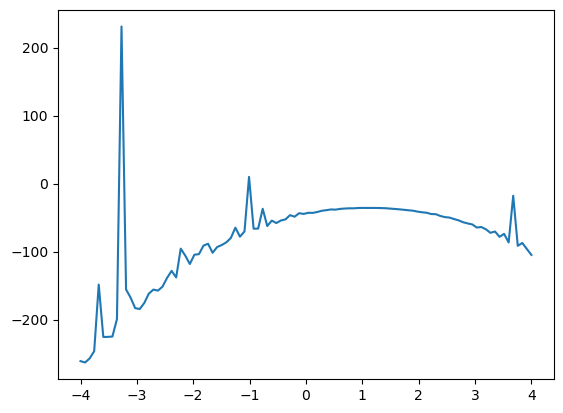

In [114]:
plt.plot(u,VD)

In [115]:
X_data

array([ 2.32410059,  1.72133206,  3.02204085,  1.28039502,  3.20599295,
        0.1306061 , -0.42252324,  1.00207099,  1.19673111,  1.1187402 ,
        1.5187491 , -2.09486165,  2.27496383, -2.02530546,  1.04995631,
       -0.92943052,  1.92954144,  1.80214269,  0.65664019,  1.50669538])

In [116]:
def log_likelihood(X_data,mu):
    mu_vector = np.zeros(20)+mu
    return -10*np.log(2*np.pi)-0.5*np.log(4)-0.5*np.dot(np.transpose(X_data-mu_vector),X_data-mu_vector)

In [117]:
HG = []
for i in range(100):
    HG.append(log_likelihood(X_data,u[i]))
HG

[-290.60083346667193,
 -282.5636215771256,
 -274.657008606057,
 -266.8809945534662,
 -259.235579419353,
 -251.72076320371747,
 -244.33654590655973,
 -237.08292752787963,
 -229.95990806767728,
 -222.9674875259526,
 -216.1056659027057,
 -209.37444319793644,
 -202.7738194116449,
 -196.30379454383106,
 -189.96436859449494,
 -183.75554156363654,
 -177.6773134512558,
 -171.72968425735283,
 -165.91265398192755,
 -160.2262226249799,
 -154.67039018651002,
 -149.24515666651786,
 -143.95052206500338,
 -138.7864863819666,
 -133.75304961740758,
 -128.8502117713262,
 -124.07797284372255,
 -119.43633283459661,
 -114.92529174394839,
 -110.54484957177786,
 -106.29500631808503,
 -102.17576198286993,
 -98.18711656613252,
 -94.32907006787282,
 -90.60162248809083,
 -87.00477382678652,
 -83.53852408395996,
 -80.20287325961107,
 -76.99782135373991,
 -73.92336836634644,
 -70.97951429743068,
 -68.16625914699263,
 -65.4836029150323,
 -62.931545601549644,
 -60.51008720654471,
 -58.219227730017494,
 -56.058967171

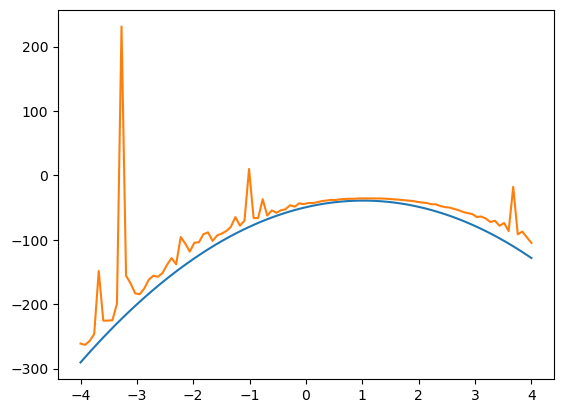

In [119]:
plt.plot(u,HG)
plt.plot(u,VD)